,Description,Value
0,Session id,123
1,Target,poverty_status
2,Target type,Binary
3,Original data shape,"(1594397, 16)"
4,Transformed data shape,"(1594397, 16)"
5,Transformed train set shape,"(1116077, 16)"
6,Transformed test set shape,"(478320, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8776,0.8951,0.5892,0.7714,0.6681,0.5947,0.6028,23.1620
xgboost,Extreme Gradient Boosting,0.8769,0.8935,0.5904,0.7674,0.6674,0.5934,0.6011,0.9060
lightgbm,Light Gradient Boosting Machine,0.8762,0.8921,0.5857,0.7673,0.6643,0.5901,0.5982,1.7230
rf,Random Forest Classifier,0.8754,0.8802,0.5880,0.7618,0.6637,0.5888,0.5962,21.5390
gbc,Gradient Boosting Classifier,0.8737,0.8846,0.5778,0.7608,0.6568,0.5812,0.5894,14.9040
et,Extra Trees Classifier,0.8697,0.8680,0.5748,0.7439,0.6485,0.5701,0.5773,31.7420
ada,Ada Boost Classifier,0.8664,0.8764,0.5317,0.7569,0.6246,0.5463,0.5589,3.3660
lr,Logistic Regression,0.8504,0.8429,0.4205,0.7557,0.5403,0.4595,0.4877,5.3250
ridge,Ridge Classifier,0.8470,0.8430,0.3753,0.7781,0.5064,0.4287,0.4686,0.2240
lda,Linear Discriminant Analysis,0.8462,0.8430,0.4424,0.7132,0.5461,0.4596,0.4786,0.3620


Best Model:  <catboost.core.CatBoostClassifier object at 0x37a205850>
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8766,0.8946,0.5858,0.7702,0.6655,0.5916,0.5999


Index(['AGEP', 'ANC1P', 'CIT', 'DIS', 'SCHL', 'ESR', 'HICOV', 'HISP', 'OCCP',
       'MAR', 'MIG', 'MIL', 'RAC1P', 'POBP', 'SEX', 'poverty_status',
       'prediction_label', 'prediction_score'],
      dtype='object')
Accuracy: 0.8766407425990969
Precision: 0.7701998330787522
Recall: 0.5858326945189728
F1 Score: 0.6654829207230375
Confusion Matrix: 
[[300519  14593]
 [ 34578  48910]]


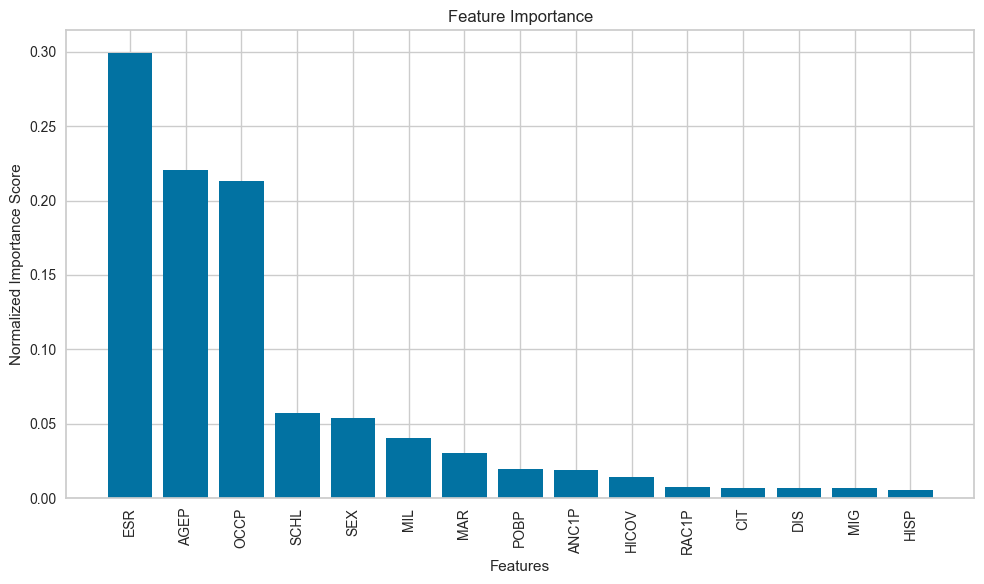

Feature Importances:
ESR: 0.2994
AGEP: 0.2207
OCCP: 0.2131
SCHL: 0.0570
SEX: 0.0538
MIL: 0.0405
MAR: 0.0301
POBP: 0.0192
ANC1P: 0.0192
HICOV: 0.0139
RAC1P: 0.0078
CIT: 0.0068
DIS: 0.0068
MIG: 0.0065
HISP: 0.0052


In [1]:
import os
import subprocess

def install(package):
    subprocess.run(f'pip install {package}', shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

install('--upgrade pip setuptools wheel')
install('cython')
install('pyyaml')
install('scipy')
install('pycaret[full]')
install('catboost')
install('xgboost')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pycaret.classification import setup, compare_models, finalize_model, save_model, load_model, predict_model

file_path = '/Users/sherryzhang/Downloads/DroppedMisVals.csv'
data = pd.read_csv(file_path)

# Define features and target
poverty_threshold = 13590
data['poverty_status'] = np.where(data['PINCP'] <= poverty_threshold, 1, 0)

# Drop the 'PINCP' column as it should not be used for prediction
data = data.drop(columns=['PINCP'])

# Define features and target
X = data.drop(columns=['poverty_status'])
Y = data['poverty_status']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18)

# Combine training features and target into one dataframe for PyCaret
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(Y_train, name='poverty_status')], axis=1)

# Set up the PyCaret environment
clf_setup = setup(data=train_data, target='poverty_status', session_id=123)

# Compare models
best_model = compare_models()

# Print the best model to see which one was selected
print("Best Model: ", best_model)

# Finalize the model (train on the entire training set)
final_model = finalize_model(best_model)

# Save the model
save_model(final_model, '/Users/sherryzhang/Downloads/best_model')

# Load the model (if needed in future)
loaded_model = load_model('/Users/sherryzhang/Downloads/best_model')

# Evaluate the model on the test set
test_data = pd.concat([pd.DataFrame(X_test), pd.Series(Y_test, name='poverty_status')], axis=1)
predictions_df = predict_model(loaded_model, data=test_data)

# Print column names to find the correct one
print(predictions_df.columns)

# Use the correct column for predicted class labels
predictions = predictions_df['prediction_label']

# Metrics
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
conf_matrix = confusion_matrix(Y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Feature importance
if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    total_importance = sum(feature_importance)
    normalized_importance = feature_importance / total_importance

    indices = np.argsort(normalized_importance)[::-1]
    names = [X.columns[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(normalized_importance)), normalized_importance[indices], align='center')
    plt.xticks(range(len(normalized_importance)), names, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance Score')
    plt.tight_layout()
    plt.show()

    # Print the feature importance values
    print("Feature Importances:")
    for name, importance in zip(names, normalized_importance[indices]):
        print(f"{name}: {importance:.4f}")
else:
    print("The selected model does not provide feature importances.")